In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from pathlib import Path

In [2]:
#!git clone https://github.com/xiaoh/para-database-for-PIML.git

In [3]:
#!pip install "pyvista[jupyter]"
#!pip install trame
# import pyvista as pv
# meshpv = pv.read("./para-database-for-PIML/pehill-29-cases-DNS/alph15-13929-4048/mean.vtr")
# structured_points = meshpv.points.reshape((*meshpv.dimensions, 3))
# print(structured_points.shape), print(grid.dimensions)
# meshpv['UMEAN'].shape

# for case in cases:
#     for fieldname in meshpv.point_data:
#         meshpv  = pv.read(base_path+'/'+case+'/mean.vtr')
#         plotter = pv.Plotter(window_size=[1200, 500])
#         plotter.add_mesh(meshpv, scalars=fieldname, show_scalar_bar=False, cmap='gray',)  
        
#         plotter.view_xy()
#         plotter.screenshot(case+'_'+fieldname+'.png')

In [4]:
def para_profile(yy, a):
    'Calculate the shape of the parameterized periodic hill'

    y = np.array(yy)
    x = y * 28
    ya = y

    h = np.zeros(len(x))

    # Must appear before the x[i] is revised in next for loop
    for i in range(len(x)):
        if (x[i]>=0) and (x[i]<54) :
            ya[i] *= a
        elif (x[i]>54) and (x[i]<=126) :
            ya[i] -= (54/28.0*(1-a))
        elif (x[i]>126) and (x[i]<=198) :
            ya[i] -= (54/28.0*(1-a))
        elif (x[i]>198) and (x[i]<=252) :
            ya[i] -= (54/28.0*(1-a))
            ya[i] -= (x[i]-198)*(1-a)/28.0
    
    for i in range(len(x)):
        if x[i] > 126.0 :
            x[i] = 252.0 - x[i]

        if (x[i]>=0) and (x[i]<9) :
            h[i] = np.minimum(28., 2.8e+01 + 0.0e+00*x[i] + \
                              6.775070969851e-03*x[i]**2 - 2.124527775800e-03*x[i]**3);
        elif (x[i]>=9) and (x[i]<14) :
            h[i] = 2.507355893131E+01 + 9.754803562315E-01*x[i] - \
                   1.016116352781E-01*x[i]**2 + 1.889794677828E-03*x[i]**3;
        elif (x[i]>=14) and (x[i]<20) :
            h[i] = 2.579601052357E+01 + 8.206693007457E-01*x[i] - \
                   9.055370274339E-02*x[i]**2 + 1.626510569859E-03*x[i]**3;
        elif (x[i]>=20) and (x[i]<30) :
            h[i] = 4.046435022819E+01 - 1.379581654948E+00*x[i] + \
                   1.945884504128E-02*x[i]**2 - 2.070318932190E-04*x[i]**3;
        elif (x[i]>=30) and (x[i]<40) :
            h[i] = 1.792461334664E+01 + 8.743920332081E-01*x[i] - \
                   5.567361123058E-02*x[i]**2 + 6.277731764683E-04*x[i]**3;
        elif (x[i]>=40) and (x[i]<=54) :
            h[i] = np.maximum(0., 5.639011190988E+01 - 2.010520359035E+00*x[i] + \
                              1.644919857549E-02*x[i]**2 + 2.674976141766E-05*x[i]**3);
        elif (x[i]>54) and (x[i]<=126) :
            h[i] = 0.0


    hout = h/28.0
    return ya, hout


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [6]:
import tarfile

def create_tar_gz(archive_name, file_list):
  with tarfile.open(archive_name, "w:gz") as tar:
    for file in file_list:
      tar.add(file, arcname=os.path.relpath(file, start=base_path)) 
      

def extract_tar_gz(archive_name, extract_path):
  with tarfile.open(archive_name, "r:gz") as tar:
    tar.extractall(path=extract_path)


In [7]:

# file_list = [os.path.join(base_path, d)+ '/mean_files.dat' for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
# archive_name = "data_files.tar.gz"
# create_tar_gz(archive_name, file_list)

In [8]:
import tarfile

if not os.path.exists("./data_files"):

  # Example usage
  extract_path = "./data_files"
  extract_tar_gz("data_files.tar.gz", extract_path)

In [9]:
base_path = './data_files'
cases = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(cases)

['alph05-7071-3036', 'alph10-9-4048', 'alph05-4071-2024', 'alph10-12-3036', 'alph05-10071-3036', 'alph15-7929-4048', 'alph15-10929-4048', 'alph10-6-2024', 'alph05-10071-2024', 'alph10-12-2024', 'alph075-80355-3036', 'alph05-4071-3036', 'alph05-7071-2024', 'alph15-13929-4048', 'alph10-6-3036', 'alph10-12-4048', 'alph05-10071-4048', 'alph05-7071-4048', 'alph10-9-3036', 'alph15-10929-3036', 'alph15-7929-3036', 'alph15-13929-2024', 'alph05-4071-4048', 'alph10-9-2024', 'alph15-13929-3036', 'alph10-6-4048', 'alph15-10929-2024', 'alph15-7929-2024', 'alph125-99645-3036']


![image](https://media.cheggcdn.com/media/ed8/ed8c8f37-f1a1-401b-af4d-453eb4d56c90/phpG5xWIV)

In [10]:
nu = 5e-6

def pde_loss(x, y, pred):

    # u, v, p, uv, uu, vv = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3], pred[:, 3:4], pred[:, 4:5], pred[:, 5:6]
    u, v, p = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
    uv_x = u*v_x
    uv_y = u*v_y
    uu_x = u*u_x
    vv_y = v*v_y
        
    f =  u * u_x + v * u_y + p_x - nu * (u_xx + u_yy) + uu_x + uv_y
    g =  u * v_x + v * v_y + p_y - nu * (v_xx + v_yy) + uv_x + vv_y
    cont = u_x + v_y
    
    f_loss = (f ** 2).mean()
    g_loss = (g ** 2).mean()
    div_loss = (cont ** 2).mean()
    
    return f_loss + g_loss + div_loss


In [11]:
def boundary_conditions_loss():
    pass
    # yep, that's strange no BC but still convergence 

In [12]:
class Net(nn.Module):
    def __init__(self, layer_dim):
        super().__init__()

        self.num_layers = len(layer_dim)
        self.layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.layers.append(nn.Linear(layer_dim[i - 1], layer_dim[i]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.tanh(layer(x))
        x = self.layers[-1](x)
        return x

In [13]:
def get_collocation_points(x_train, y_train, n_points=7000):
    idx = np.random.choice(x_train.shape[0], n_points, replace=False)
    x_sample = torch.tensor(x_train[idx, :], dtype=torch.float32)
    y_sample = torch.tensor(y_train[idx, :], dtype=torch.float32)
    x_sample = x_sample.to(device)
    y_sample = y_sample.to(device)
    return x_sample, y_sample

In [14]:
def train_model(model, optimizer, iterations, x_train, y_train, n_points=7000):
    logs = {
        "iteration": [],
        "loss_from_pde": [],
        "loss_from_data": [],
        "total_loss": [],
    }
    def closure():
        
        x_train_sample, y_train_sample = get_collocation_points(x_train, y_train, n_points)
        
        x, y = x_train_sample[:, 0:1], x_train_sample[:, 1:2]
        x.requires_grad_(True)
        y.requires_grad_(True)
        input_tensor = torch.cat([x, y], dim=1)
        pred = model(input_tensor)

        optimizer.zero_grad()
        loss_from_data = F.mse_loss(pred[:,0:3], y_train_sample)

        loss_from_pde = pde_loss(x, y, pred)
        loss = loss_from_pde + loss_from_data
        loss.backward()
        closure.iteration += 1

        logs["iteration"].append(closure.iteration)
        logs["loss_from_pde"].append(loss_from_pde.item())
        logs["loss_from_data"].append(loss_from_data.item())
        logs["total_loss"].append(loss.item())
        if closure.iteration % 50 == 0:
            print(
                f"Iteration {closure.iteration}. Pde loss: {loss_from_pde.item()}, data loss: {loss_from_data.item()}"
            )
        return loss
    
    closure.iteration = 0
    try:
        for iteration in range(iterations):
            loss = optimizer.step(closure)
            
    except KeyboardInterrupt: 
        print('training stopped manually')
    
    return logs


def plot_training_logs(logs):
    plt.figure(figsize=(10, 6))
    plt.plot(logs["iteration"], logs["loss_from_pde"], label="PDE Loss")
    plt.plot(
        logs["iteration"], logs["loss_from_data"], label="Data Conditions Loss"
    )
    plt.plot(logs["iteration"], logs["total_loss"], label="Total Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Losses")
    plt.legend()
    plt.show()


In [15]:
def get_predictions(x, y, model):
    mesh = torch.tensor(np.stack((x, y), axis=1), dtype=torch.float32).to(device)
    preds = model(mesh)
    return (
        preds[:, 0].detach().cpu().numpy(),
        preds[:, 1].detach().cpu().numpy(),
        preds[:, 2].detach().cpu().numpy()
    )

def plot_flow_variables(x, y, *variables):
    labels      = ['u' , 'v' , 'p'] 
    n_variables = len(variables)
    fig, ax = plt.subplots(n_variables, 1, figsize=(12,12))

    profile_sweep=np.arange(0, 9, 0.01)
    alpha = 0.5

    x_profile, y_profile = para_profile(profile_sweep, alpha)
    
    xend = x_profile[-1]
    outline = np.array([[0, 0, xend, xend], [1, 3.06, 3.06, 1]])

    for i, variable in enumerate(variables):
        contour = ax[i].tricontourf(x.flatten(), y.flatten(),
                                    variable.flatten(), levels=50)
        ax[i].plot(outline[0], outline[1], 'r')
        ax[i].plot(x_profile, y_profile, 'r')
        ax[i].set_aspect(1)
        ax[i].set_title(labels[i])
        fig.colorbar(contour, ax=ax[i])
    plt.savefig('./'+case+'.png', dpi=300)


def relative_l2_error(u_predicted, u_exact):
    numerator = np.linalg.norm(u_predicted - u_exact, axis=0)
    denominator = np.linalg.norm(u_exact, axis=0)
    relative_error = numerator / denominator
    return relative_error

alph05-7071-3036
Iteration 50. Pde loss: 0.00010992062016157433, data loss: 0.007322222460061312
Iteration 100. Pde loss: 0.0002751493011601269, data loss: 0.004690405447036028
training stopped manually
Flow relative errors: [0.08024707 4.29426224 5.4222817 ]


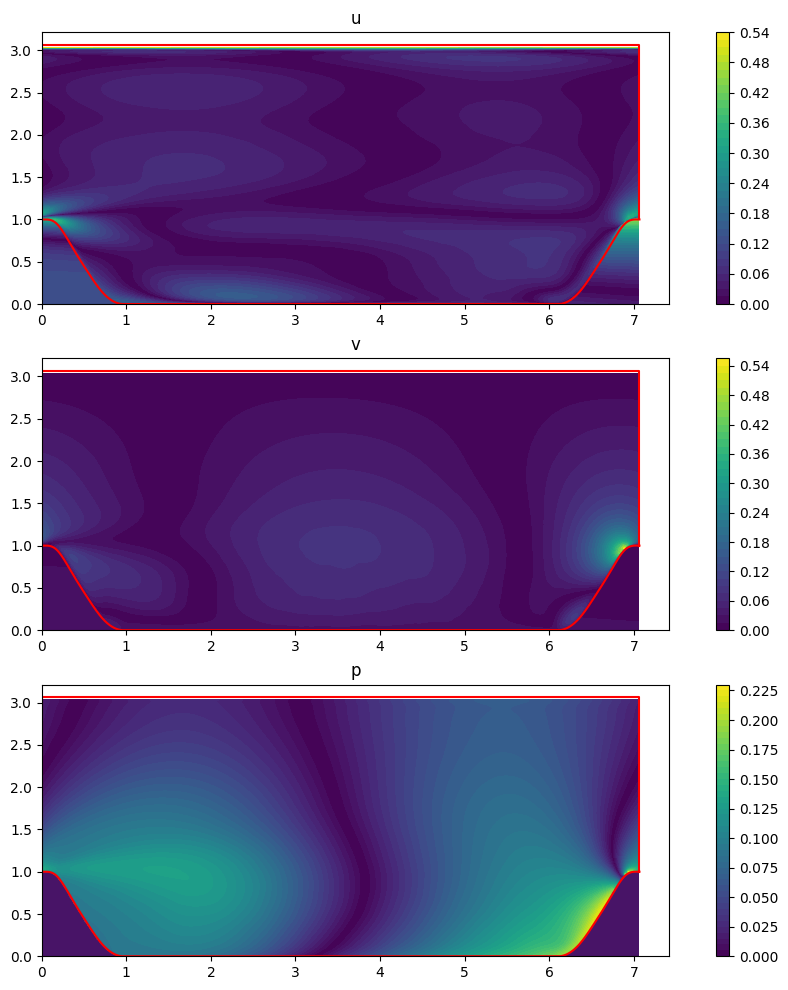

In [20]:
input_dim = 2
output_dim = 3
n_layers = 8
layer_dim = 256
model_architecrure = [input_dim] + n_layers * [layer_dim] + [output_dim]
n_points = 2000
lr = 0.001
iterations = 8000
if not os.path.exists('./models'):
    os.makedirs('./models')


for case in cases:
    print(case)

    data = np.genfromtxt(base_path+'/'+case+'/mean_files.dat')
    x, y, u, v, w, p      = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5]
    flow_variables_arrays = [u, v, p]

    x_train = np.stack((x, y), axis=1)
    y_train = np.stack((flow_variables_arrays), axis=1)

    model = Net(model_architecrure).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    logs = train_model(model, optimizer, iterations, x_train, y_train, n_points=4000)
    # plot_training_logs(logs)

    preds = get_predictions(x, y, model)
    flow_absolute_errors = np.abs(y_train - np.stack(preds, axis=1))
    flow_relative_errors = relative_l2_error(y_train, np.stack(preds, axis=1))
    print(f"Flow relative errors: {flow_relative_errors}")
    # plot_flow_variables(x, y, *preds)
    plot_flow_variables(x, y, *flow_absolute_errors.T)

    # torch.save(model.state_dict(), f'./models/{case}_model.pth')
    break


In [19]:
y_train.shape, np.stack(preds, axis=1).shape

((246400, 3), (246400, 3))

In [49]:
# # LBFGS optimizer
# lr = 0.1
# iterations = 100
# optimizer = optim.LBFGS(
#     model.parameters(),
#     lr=lr,
#     max_iter=12000,
#     max_eval=12000,
#     history_size=400,
#     tolerance_grad=1e-11,
#     tolerance_change=1e-14,
#     line_search_fn="strong_wolfe",
# )

# logs = train_model(model, optimizer, iterations, x_train, y_train)
# plot_training_logs(logs)